<a href="https://colab.research.google.com/github/akiabe/coursera-dl-tf-in-practice/blob/master/C4W4_Sunspots_kaggle_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

In [0]:
# Define helper function of plotting chart
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Access server and download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-06-13 18:53:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-06-13 18:53:40 (149 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
# Read the csv file and get data into a list of sunspots and timesteps
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  # Read the column title and end up throwing it away
  next(reader)
  # Loop through the reader and append data into list
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
  
  # Convert list into numpy array
  series = np.array(sunspots)
  time = np.array(time_step)

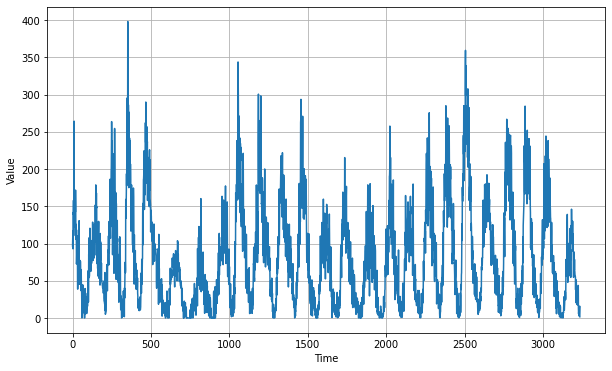

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
# Split dataset into training and validation sets
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Set the constans that pass to the windowed_dataset function
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Define helper function of turning the data into a window dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Create dataset from series and pass the series to it
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # Window the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Mapping a dataset element to a (window_size + 1) batch size dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Shuffle the dataset at the shuffle_buffer and split into features and labels
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # Batch the select batch size
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [8]:
# Set the dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)   
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1
)

print("Training Complete!")

Epoch 1/100
92/92 [==============================] - 0s 4ms/step - loss: 3564.5525
Epoch 2/100
92/92 [==============================] - 0s 4ms/step - loss: 1004.5651
Epoch 3/100
92/92 [==============================] - 0s 4ms/step - loss: 897.4523
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 849.2305
Epoch 5/100
92/92 [==============================] - 0s 4ms/step - loss: 811.3339
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 799.7053
Epoch 7/100
92/92 [==============================] - 0s 4ms/step - loss: 774.6329
Epoch 8/100
92/92 [==============================] - 0s 4ms/step - loss: 760.2231
Epoch 9/100
92/92 [==============================] - 0s 4ms/step - loss: 749.9989
Epoch 10/100
92/92 [==============================] - 0s 4ms/step - loss: 742.6067
Epoch 11/100
92/92 [==============================] - 0s 4ms/step - loss: 733.9156
Epoch 12/100
92/92 [==============================] - 0s 4ms/step - loss: 721.3333
Epoch 13/10

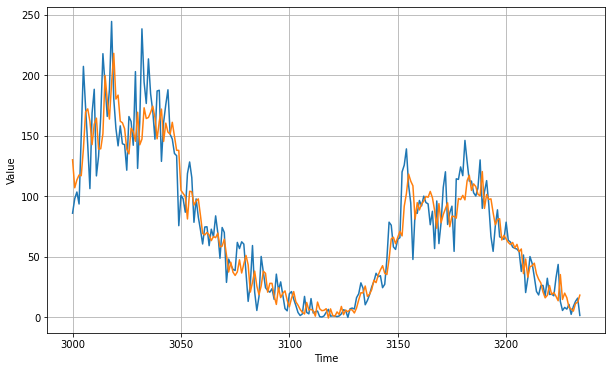

In [9]:
# Forecast every time points of time series
forecast=[]

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.627637

In [11]:
# Chage the window_size and retrain the same model
window_size = 30

# Set the dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)   
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1
)

print("Training Complete!")

Epoch 1/100
93/93 [==============================] - 0s 3ms/step - loss: 1906.7268
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 946.1017
Epoch 3/100
93/93 [==============================] - 0s 4ms/step - loss: 878.6707
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 827.8975
Epoch 5/100
93/93 [==============================] - 0s 4ms/step - loss: 791.6923
Epoch 6/100
93/93 [==============================] - 0s 4ms/step - loss: 763.7803
Epoch 7/100
93/93 [==============================] - 0s 3ms/step - loss: 744.6905
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 737.3764
Epoch 9/100
93/93 [==============================] - 0s 4ms/step - loss: 718.5035
Epoch 10/100
93/93 [==============================] - 0s 4ms/step - loss: 711.3188
Epoch 11/100
93/93 [==============================] - 0s 4ms/step - loss: 701.9280
Epoch 12/100
93/93 [==============================] - 0s 3ms/step - loss: 697.0555
Epoch 13/100

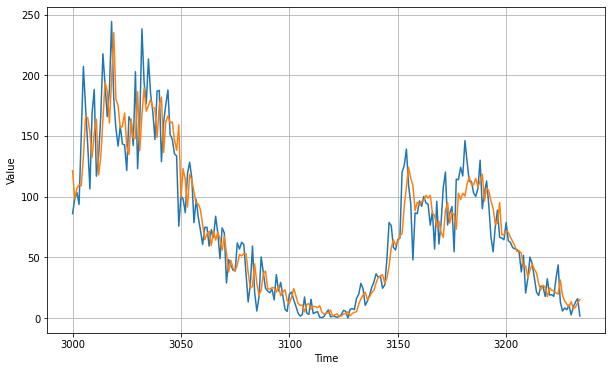

In [12]:
# Forecast every time points of time series
forecast=[]

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.481601

In [14]:
# Chage the input layer size
window_size = 30

# Set the dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Buld the convolutional and LSTM-based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
  tf.keras.layers.Dense(15, activation="relu"),
  tf.keras.layers.Dense(1)   
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(
    loss="mse",
    optimizer=optimizer
)

history = model.fit(
    train_set,
    epochs=100,
    verbose=1
)

print("Training Complete!")

Epoch 1/100
93/93 [==============================] - 0s 4ms/step - loss: 2419.1919
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 922.8594
Epoch 3/100
93/93 [==============================] - 0s 4ms/step - loss: 824.8364
Epoch 4/100
93/93 [==============================] - 0s 4ms/step - loss: 771.2665
Epoch 5/100
93/93 [==============================] - 0s 4ms/step - loss: 746.2003
Epoch 6/100
93/93 [==============================] - 0s 3ms/step - loss: 729.8701
Epoch 7/100
93/93 [==============================] - 0s 4ms/step - loss: 720.3651
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 708.2728
Epoch 9/100
93/93 [==============================] - 0s 4ms/step - loss: 702.7378
Epoch 10/100
93/93 [==============================] - 0s 4ms/step - loss: 688.2401
Epoch 11/100
93/93 [==============================] - 0s 3ms/step - loss: 686.8976
Epoch 12/100
93/93 [==============================] - 0s 3ms/step - loss: 679.8069
Epoch 13/100

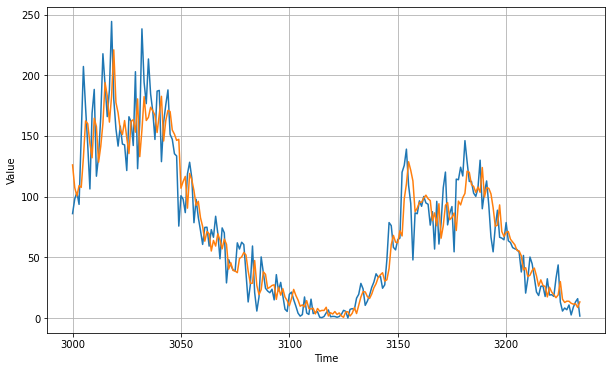

In [15]:
# Forecast every time points of time series
forecast=[]

# Iterate over the series and taking slice the window size and predict them
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Split results after the split time and load them into numpy array
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

# Plot results
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
# Compute mean absolute error and check the size of error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.6749

In [17]:
# Prediction
model.predict(series[3205:3235][np.newaxis])

array([[2.860163]], dtype=float32)